In [1]:
from google.colab import drive
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTImageProcessor
from collections import Counter
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
import time
from tqdm import tqdm
import torch
import timm
import matplotlib.pyplot as plt
import copy
from torchvision.models import vit_b_16
from collections import Counter
from tqdm import tqdm # for progress bar
import random
import os

In [2]:
#drive.mount('/content/drive')

In [3]:
data_dir = '/kaggle/input/aav-spectrogram/spectrogram'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:
# Test loading
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)  # Should be [B, C, 224, 224]

Batch shape: torch.Size([16, 3, 224, 224])


In [5]:
batch_size = 32
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

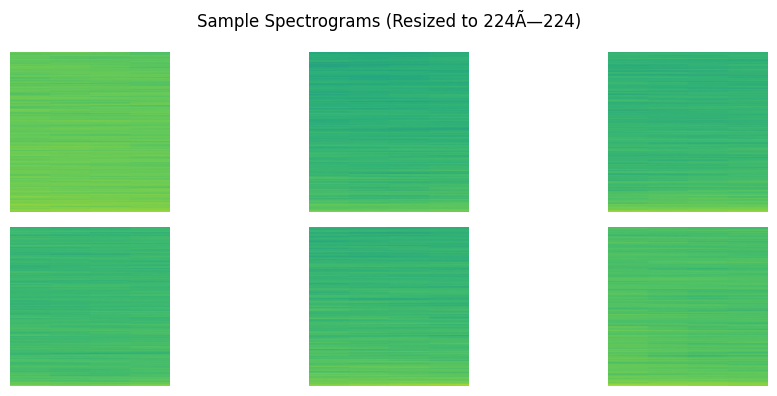

In [6]:
plt.figure(figsize=(10, 4))
for i in range(6):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze(), cmap='viridis')
    plt.axis('off')
plt.suptitle("Sample Spectrograms (Resized to 224Ã—224)")
plt.tight_layout()
plt.show()

In [7]:


def count_images_per_class(train_loader):
    """Counts the number of images per class in a train_loader.

    Args:
        train_loader: The DataLoader for the training dataset.

    Returns:
        A dictionary where keys are class labels and values are the corresponding counts.
    """

    all_labels = []
    for images, labels in tqdm(train_loader, desc="Counting images per class"):
        all_labels.extend(labels.tolist())  # Extend the list with labels from the batch

    class_counts = Counter(all_labels)  # Count occurrences of each label

    return class_counts

In [8]:
# Get the counts and print them
class_counts = count_images_per_class(train_loader)

print("Images per class in train_loader:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

Counting images per class: 100%|██████████| 88/88 [00:17<00:00,  4.98it/s]

Images per class in train_loader:
Class 0: 830 images
Class 2: 1235 images
Class 1: 745 images


In [9]:
# Get the counts and print them
class_counts = count_images_per_class(val_loader)

print("Images per class in train_loader:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

Counting images per class: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]

Images per class in train_loader:
Class 0: 205 images
Class 2: 321 images
Class 1: 177 images


In [10]:
def extract_blocks(image, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    # Extract a central context block.
    _, H, W = image.shape
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    context_block = image[:, top:top+context_size, left:left+context_size]
    context_block = torch.nn.functional.interpolate(context_block.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
    
    # Extract num_targets target blocks randomly.
    target_blocks = []
    for _ in range(num_targets):
        target_size = int(target_scale * H)
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        target_block = image[:, top_t:top_t+target_size, left_t:left_t+target_size]
        target_block = torch.nn.functional.interpolate(target_block.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        target_blocks.append(target_block)
    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks, (top, left, context_size), None

In [11]:
class IJEPADataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, context_scale=0.85, target_scale=0.2, num_targets=4):
        self.base_dataset = base_dataset
        self.context_scale = context_scale
        self.target_scale = target_scale
        self.num_targets = num_targets
        
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        context_block, target_blocks, _, _ = extract_blocks(image, self.context_scale, self.target_scale, self.num_targets)
        return context_block, target_blocks, label

In [12]:
train_ijepa_dataset = IJEPADataset(train_dataset)
val_ijepa_dataset   = IJEPADataset(val_dataset)


train_loader = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_ijepa_dataset, batch_size=32, shuffle=False)

In [13]:
def get_vit_encoder():
    model = vit_b_16(pretrained=False)
    model.heads = nn.Identity()  # remove classification head
    return model

In [14]:

context_encoder = get_vit_encoder().cuda()
target_encoder  = get_vit_encoder().cuda()
target_encoder.load_state_dict(context_encoder.state_dict())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [15]:
class Predictor(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, output_dim=768, num_targets=4):
        super().__init__()
        self.num_targets = num_targets
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_targets)
        )
    def forward(self, context_repr):
        pred = self.mlp(context_repr)
        # Reshape to [B, num_targets, output_dim]
        return pred.view(-1, self.num_targets, pred.size(-1) // self.num_targets)

In [16]:
# 6. Set up optimizer, loss, and EMA update (same as your CIFAR code).
predictor = Predictor().cuda()
optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=1e-3)
criterion = nn.MSELoss()
ema_decay = 0.99

In [17]:
@torch.no_grad()
def update_ema(model, model_ema, beta):
    for param, param_ema in zip(model.parameters(), model_ema.parameters()):
        param_ema.data.mul_(beta).add_(param.data, alpha=1 - beta)

In [18]:
# Create a directory for visualizations if it doesn't exist.
viz_dir = "/kaggle/working/viz"
os.makedirs(viz_dir, exist_ok=True)

num_epochs = 1
ema_decay = 0.99
best_loss = float('inf')
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    context_encoder.train()
    predictor.train()
    running_loss = 0.0
    
    # Enumerate over batches with a progress bar.
    for batch_idx, (context_block, target_blocks, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        context_block = context_block.cuda()            # [B, C, 224, 224]
        target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]
        
        # Forward pass through context encoder and predictor.
        context_repr = context_encoder(context_block)     # [B, 768]
        preds = predictor(context_repr)                   # [B, num_targets, 768]
        
        B, num_targets, C, Ht, Wt = target_blocks.shape
        target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
        with torch.no_grad():
            target_repr_flat = target_encoder(target_blocks_flat)
        target_repr = target_repr_flat.view(B, num_targets, -1)
        
        loss = criterion(preds, target_repr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(context_encoder, target_encoder, ema_decay)
        running_loss += loss.item() * context_block.size(0)
        
        # --- Visualization for first image of the current batch ---
        '''with torch.no_grad():
            # Get the first sample's context block and compute its feature vector.
            context_img = context_block[0].cpu()  # shape: [C, 224, 224]
            context_feat = context_encoder(context_block[0].unsqueeze(0)).cpu().squeeze(0)  # shape: [768]
            # Reshape feature vector to a 2D heatmap (24x32).
            context_heat = context_feat.view(24, 32).numpy()
            
            # For target, choose the first target block of the first sample.
            target_img = target_blocks[0][0].cpu()  # shape: [C, 224, 224]
            target_feat = target_encoder(target_blocks[0][0].unsqueeze(0).to(context_block.device)).cpu().squeeze(0)
            target_heat = target_feat.view(24, 32).numpy()
            
            # Plot the images and corresponding heatmaps.
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))
            
            # Display context block image.
            if context_img.shape[0] == 1:
                axs[0, 0].imshow(context_img.squeeze(), cmap='gray')
            else:
                axs[0, 0].imshow(context_img.permute(1, 2, 0))
            axs[0, 0].set_title("Context Block")
            axs[0, 0].axis("off")
            
            # Display context feature heatmap.
            im0 = axs[0, 1].imshow(context_heat, cmap="viridis")
            axs[0, 1].set_title("Context Feature Heatmap")
            axs[0, 1].axis("off")
            fig.colorbar(im0, ax=axs[0, 1])
            
            # Display target block image.
            if target_img.shape[0] == 1:
                axs[1, 0].imshow(target_img.squeeze(), cmap='gray')
            else:
                axs[1, 0].imshow(target_img.permute(1, 2, 0))
            axs[1, 0].set_title("Target Block")
            axs[1, 0].axis("off")
            
            # Display target feature heatmap.
            im1 = axs[1, 1].imshow(target_heat, cmap="viridis")
            axs[1, 1].set_title("Target Feature Heatmap")
            axs[1, 1].axis("off")
            fig.colorbar(im1, ax=axs[1, 1])
            
            # Save the visualization figure with epoch and batch number.
            viz_path = os.path.join(viz_dir, f"epoch{epoch+1}_batch{batch_idx+1}.png")
            plt.savefig(viz_path)
            plt.close(fig)'''
    
    epoch_loss = running_loss / len(train_ijepa_dataset)
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Epoch Time: {epoch_time:.2f}s")
    
    # Save checkpoint if current epoch loss is lower than previous best.
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            'epoch': epoch+1,
            'context_encoder_state_dict': context_encoder.state_dict(),
            'target_encoder_state_dict': target_encoder.state_dict(),
            'predictor_state_dict': predictor.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }
        torch.save(checkpoint, "/kaggle/working/ijepa_checkpoint_best.pth")
        print(f"Checkpoint saved at epoch {epoch+1} with loss {epoch_loss:.4f}")

total_train_time = time.time() - total_start_time
print(f"Total Training Time: {total_train_time:.2f}s")

Epoch 1/1 - Train Loss: 0.0533 - Epoch Time: 144.25s
Checkpoint saved at epoch 1 with loss 0.0533
Total Training Time: 146.11s
